In [1]:
%load_ext autoreload
%autoreload 2

# Udacity Deep Reinforcement Learning Nanodegree - Project 3: Collaboration and Competition

(The paper "Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments" by Lowe et al. from OpenAI and UC Berkeley)[https://arxiv.org/pdf/1706.02275.pdf]

In [12]:
from collections import deque
import time

from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import torch

from agent import Agent
from utils import ReplayBuffer

## Set everything up

* Parameters
* Unity environment
* Agent

## Parameters

In [3]:
params = {
    'buffer_size': 2e5,
    'batch_size': 256,
    'n_random_episodes': 500,
    'n_episodes': 2000,    
    'max_steps': 750,
    'update_step': 4,
    'solution_threshold': .5,
    'eval_window_length': 100,
    'num_agents': 2,
    'agent_seed': 33,
    'env_seed': 33,
    'buffer_seed': 33,
    'gamma': 0.95,
    'tau': 1e-2,
    'first_hidden_units': 256,
    'second_hidden_units': 256,
    'lr_actor': 1e-3,
    'lr_critic': 1e-3,
    'critic_weight_decay': 0,
    'add_noise': True,
    'noise_sigma': 0.2,
    'noise_scale_start': 2.0,
    'noise_scale_min': 0.2,
    'noise_scale_decay': 0.9995
}

## Instantiate Multi-Agent DDPG Tennis environment

In [4]:
env = UnityEnvironment(file_name="Tennis.app",
                       seed=params['env_seed'],
                       no_graphics=False)
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.93938923 -1.5
 -0.          0.         -7.46356201  6.         -0.          0.        ]


In [6]:
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

## Instantiate multiple DDPG Agent and Shared Replay Buffer

In [7]:
agents = {}
for num_agent in range(params['num_agents']):
    agents[num_agent] = Agent(state_size=state_size, action_size=action_size,
                              agent_no=num_agent, params=params)

replay_buffer = ReplayBuffer(params=params)

TODO: Transform into simple tuple of agents, saves the additionale chores of caring about the indices

## Train the Agent with DDPG (Deep Deterministic Policy Gradients)

In [8]:
eval_window_lengths = params['eval_window_length']
env_is_solved = False
scores = []
scores_window = deque(maxlen=eval_window_lengths)
noise_scale = params['noise_scale_start']
best_score = 0

Prefill Replay Buffer with Random Samples for better Exploration

In [9]:
print('Filling Replay Buffer with random samples for {} episodes...'.format(params['n_random_episodes']))
start = time.time()
for i_episode in range(1, params['n_random_episodes']+params['n_episodes']+1):
    episode_scores = np.zeros(params['num_agents'])
    for agent in agents.values():
        agent.reset()
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    episode_start = time.time()
    
    if i_episode < params['n_random_episodes']:
        for step in range(params['max_steps']):
            actions = np.random.uniform(-1, 1, (params['num_agents'], action_size))
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            replay_buffer.add(states, actions, rewards, next_states, dones)

            states = next_states

            if np.any(dones):
                break

        # buffer_load_ratio = len(replay_buffer)/replay_buffer.buffer_size
        # print('\rEpisode {}\tBuffer Load Ratio: {:.1%}'.format(i_episode, buffer_load_ratio), end="")
    
    else:
        for step in range(params['max_steps']):
            actions = [agent.act(env_info.vector_observations[no_agent],
                                 add_noise=params['add_noise'],
                                 scale=noise_scale)
                       for no_agent, agent in agents.items()]
            actions = np.concatenate(actions, axis=0).reshape((params['num_agents'], action_size))

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            replay_buffer.add(states, actions, rewards, next_states, dones)

            for agent in agents.values():
                agent.step(replay_buffer, agents)

            episode_scores += rewards
            states = next_states
            noise_scale = max(params['noise_scale_min'], noise_scale*params['noise_scale_decay'])

            if np.any(dones):
                break
    
    buffer_load_ratio = len(replay_buffer)/replay_buffer.buffer_size
    episode_duration = time.time() - episode_start
    score = max(episode_scores)
    scores.append(score)
    np.save('maddpg_scores', scores)
    scores_window.append(score)
    
    print('\rEpisode {:4d} - Score: {:.2f} - Buffer Load Ratio: {:.1%} - Noise Scale: {:.2f} - Duration: {:.1f}[s]'.format(
        i_episode, score, buffer_load_ratio, noise_scale, episode_duration), end="")
    
    if i_episode % params['eval_window_length'] == 0:
            print('\rEpisode {:4d} - Average Score: {:.2f} - Buffer Load Ratio: {:.1%} - Total Time since Start: {:4d}[s]'.format(
                i_episode, np.mean(scores_window), buffer_load_ratio, int(time.time() - start)))
            
    if (np.mean(scores_window) >= params['solution_threshold']) & (not env_is_solved):
        print('\nEnvironment solved in {:4d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                      np.mean(scores_window)))
        env_is_solved = True
        
    if env_is_solved & (score > best_score):
        best_score = score
        for no, agent in agents.items():
            torch.save(agent.actor_local.state_dict(), 'agent_{}_best_actor_e_{}.pth'.format(no, i_episode))
            torch.save(agent.critic_local.state_dict(), 'agent_{}_best_critic_e_{}.pth'.format(no, i_episode))
    
print('Score (max over agents) from episode {} ({} steps): {}'.format(i_episode, step, np.max(scores)))

Filling Replay Buffer with random samples for 500 episodes...
Episode  100 - Average Score: 0.00 - Buffer Load Ratio: 1.0% - Total Time since Start:    8[s]
Episode  200 - Average Score: 0.00 - Buffer Load Ratio: 1.9% - Total Time since Start:   14[s]
Episode  300 - Average Score: 0.00 - Buffer Load Ratio: 2.8% - Total Time since Start:   20[s]
Episode  400 - Average Score: 0.00 - Buffer Load Ratio: 3.6% - Total Time since Start:   26[s]
Episode  500 - Average Score: 0.00 - Buffer Load Ratio: 4.5% - Total Time since Start:   31[s]
Episode  600 - Average Score: 0.00 - Buffer Load Ratio: 5.2% - Total Time since Start:   54[s]
Episode  700 - Average Score: 0.00 - Buffer Load Ratio: 5.9% - Total Time since Start:   77[s]
Episode  800 - Average Score: 0.00 - Buffer Load Ratio: 6.6% - Total Time since Start:  101[s]
Episode  900 - Average Score: 0.01 - Buffer Load Ratio: 7.5% - Total Time since Start:  132[s]
Episode 1000 - Average Score: 0.01 - Buffer Load Ratio: 8.3% - Total Time since Sta

In [10]:
env.close()

## Performance Plot

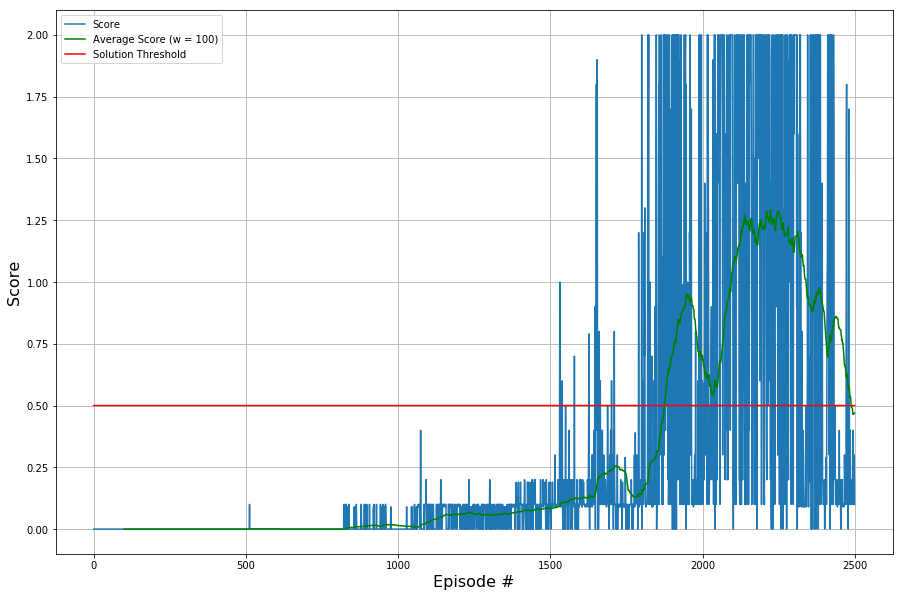

In [13]:
average_scores = np.array([np.mean(scores[i:(i+params['eval_window_length'])])
                           for i in range(len(scores)-params['eval_window_length'])])
steps = len(scores)

fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), scores, linewidth=1.5)
plt.plot(np.arange(params['eval_window_length'], steps), average_scores, 'g-')
plt.plot(np.arange(steps), [params['solution_threshold']]*steps, 'r-')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode #', fontsize=16)
plt.legend(['Score', 'Average Score (w = 100)', 'Solution Threshold'])
plt.grid(True)
plt.show()

In [15]:
print("Environment was solved in Episode {}!".format(
      np.argmax((np.array(scores) >= params['solution_threshold']))+params['eval_window_length']))

Environment was solved in Episode 1631!


In [16]:
print("First Episode with Agent-Average Score >= 0.5: {}!".format(
      np.argmax(np.array(scores) >= params['solution_threshold'])))

First Episode with Agent-Average Score >= 0.5: 1531!
